In [1]:
import os
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, tensor
from utils.load_folktables import load_folktables_torch
from src.algorithms.c_utils.constraint_fns import *
from fairret.statistic import *

This notebook presents some useful plots based on the performance of the trained models.

### **Preparation**

**Load the Folktables dataset for the selected state and prepare it for usage**

In [2]:
TASK = 'income'
# TASK = 'employment'
STATE = 'OK'

In [3]:
X_train, y_train, [w_idx_train, nw_idx_train], X_test, y_test, [w_idx_test, nw_idx_test] = load_folktables_torch(
        TASK, state=STATE, random_state=42, make_unbalanced = False, onehot=False
    )

sensitive_value_0 = 'white'
sensitive_value_1 = 'non-white'

In [4]:
device = 'cuda' if torch.cuda.is_available() and False else 'cpu'

In [5]:
X_train_tensor = tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = tensor(y_train, dtype=torch.float, device=device)
    
X_test_tensor = tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = tensor(y_test, dtype=torch.float, device=device)
    
X_train_w = X_train_tensor[w_idx_train]
y_train_w = y_train_tensor[w_idx_train]
X_train_nw = X_train_tensor[nw_idx_train]
y_train_nw = y_train_tensor[nw_idx_train]
    
X_test_w = X_test_tensor[w_idx_test]
y_test_w = y_test_tensor[w_idx_test]
X_test_nw = X_test_tensor[nw_idx_test]
y_test_nw = y_test_tensor[nw_idx_test]

In [6]:
print('w, nw, total')
print('train')
print(len(y_train_w), len(y_train_nw), len(y_train))
print(sum(y_train_w == 1)/len(y_train_w), sum(y_train_nw == 1)/len(y_train_nw), sum(y_train_tensor == 1)/len(y_train_tensor))
print('test')
print(len(y_test_w), len(y_test_nw), len(y_test))
print(sum(y_test_w == 1)/len(y_test_w), sum(y_test_nw == 1)/len(y_test_nw), sum(y_test_tensor == 1)/len(y_test_tensor))

w, nw, total
train
10680 3653 14333
tensor(0.3081) tensor(0.2078) tensor(0.2825)
test
2670 914 3584
tensor(0.3075) tensor(0.2068) tensor(0.2818)


**Load saved models**

In [7]:
loaded_models = []

In [8]:
LOSS_BOUND = 0.005
DATASET = TASK + '_' + STATE
constraint = 'loss'
DIRECTORY_PATH = "./utils/saved_models/" + DATASET + '/'+ constraint + '/' + f'{LOSS_BOUND:.0e}' + '/'
FILE_EXT = '.pt'

In [9]:
class SimpleNet(nn.Module):
    def __init__(self, in_shape, out_shape):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_shape, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, out_shape),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
directory_path = DIRECTORY_PATH
file_list = os.listdir(directory_path)
model_files = [file for file in file_list if file.endswith(FILE_EXT)]
for model_file in model_files:
    # if model_file.startswith('sg_a'):
    #     continue
    model_name = model_file
    model = SimpleNet(X_test.shape[1], 1).to(device)
    print(model_file, end='\r')
    try:
        model.load_state_dict(torch.load(directory_path + model_name, weights_only=False, map_location=device))
    except:
        continue
    model_file = str.join('', model_file.split('_trial')[:-1])
    loaded_models.append((model_file, model))

In [11]:
def get_alg_name(alg:str):
    if alg.startswith('swsg'):
        return 'Switching Subgradient'
    elif alg.startswith('sgd'):
        return 'SGD'
    elif alg.startswith('sg'):
        return 'Stochastic Ghost'
    elif alg.startswith('sslalm_mu0'):
        return 'ALM'
    elif alg.startswith('sslalm'):
        return 'SSL-ALM'
    elif alg.startswith('fairret'):
        return 'SGD + Fairret'

**Define some fairness metrics**

In [12]:
from fairret.statistic import *


def fair_stats(p_1, y_1, p_2, y_2):
    p = torch.concat([torch.tensor(p_1), torch.tensor(p_2)]).unsqueeze(1)
    w_onehot = torch.tensor([[0., 1.]]*len(p_1))
    b_onehot = torch.tensor([[1., 0.]]*len(p_2))
    sens = torch.vstack([w_onehot,b_onehot])
    labels = torch.concat([torch.tensor(y_1), torch.tensor(y_2)]).unsqueeze(1)
    pr0, pr1 = PositiveRate()(p, sens)
    fpr0, fpr1 = FalsePositiveRate()(p, sens, labels)
    tpr0, tpr1 = TruePositiveRate()(p, sens, labels)
    tnr0, tnr1 = 1-fpr0, 1-fpr1
    fnr0, fnr1 = 1-tpr0, 1-tpr1
    acc0, acc1 = Accuracy()(p, sens, labels)
    ppv0, ppv1 = PositivePredictiveValue()(p, sens, labels)
    fomr0, fomr1 = FalseOmissionRate()(p,sens,labels)
    npv0, npv1 = 1- fomr0, 1-fomr1 
    
    ind = abs(pr0 - pr1)
    sp = abs(tpr0 - tpr1) + abs(fpr0 - fpr1)
    
    ina = sum(np.concatenate([p_1, p_2]) != np.concatenate([y_1, y_2])) / (len(p_1) + len(p_2))
    # ina = (1-np.mean([acc0, acc1]))
    sf = abs(ppv0 - ppv1) + abs(npv0 - npv1)
    return ind, sp, ina, sf

### **Evaluation**

**Calculate test set statistics for the models - AUC, constraint satisfaction, loss, etc.**

In [13]:

import ot

@torch.inference_mode()
def make_model_stats_table(X_w, y_w, X_nw, y_nw):
    
    results_list = []
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    for model_index, model_iter in enumerate(loaded_models):
        (model_name, model) = model_iter
        
        # else:
        alg = model_name
        predictions_0 = model(X_w)
        predictions_1 = model(X_nw)
        if torch.any(torch.isnan(predictions_0)) or torch.any(torch.isnan(predictions_1)):
            print(f'skipped {model_name}')
            continue
        y_w = y_w.squeeze()
        y_nw = y_nw.squeeze()
        l_0 = loss_fn(predictions_0[:,0], y_w).cpu().numpy()
        l_1 = loss_fn(predictions_1[:,0], y_nw).cpu().numpy()
        predictions_0 = torch.nn.functional.sigmoid(predictions_0[:,0])
        predictions_1 = torch.nn.functional.sigmoid(predictions_1[:,0])
        # Calculate AUCs for sensitive attribute 0
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_w.cpu().numpy(), predictions_0.cpu().numpy())
        auc_0 = auc(fpr_0, tpr_0)
        # Calculate AUCs for sensitive attribute 1
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_nw.cpu().numpy(), predictions_1.cpu().numpy())
        auc_1 = auc(fpr_1, tpr_1)
        auc_hm = (auc_0*auc_1)/(auc_0 + auc_1)
        auc_m = (auc_0+auc_1)/2
        # Calculate TPR-FPR difference for sensitive attribute 0
        tpr_minus_fpr_0 = tpr_0 - fpr_0
        optimal_threshold_index_0 = np.argmax(tpr_minus_fpr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate TPR-FPR difference for sensitive attribute 1
        tpr_minus_fpr_1 = tpr_1 - fpr_1
        optimal_threshold_index_1 = np.argmax(tpr_minus_fpr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]
        
        p_0_np = (predictions_0 > 0.5).cpu().numpy()
        p_1_np = (predictions_1 > 0.5).cpu().numpy()
        y_w_np = y_w.cpu().numpy()
        y_nw_np = y_nw.cpu().numpy()
        
        ind, sp, ina, sf = fair_stats(p_0_np, y_w_np, p_1_np, y_nw_np)

        a0, x0 = np.histogram(predictions_0, bins=50)
        a1, x1 = np.histogram(predictions_1, bins=x0)
        a0 = a0.astype(float)
        a1 = a1.astype(float)
        a0 /= np.sum(a0)
        a1 /= np.sum(a1)
        wd = ot.wasserstein_1d(x0[1:], x1[1:], a0, a1, p=2)
        # Store results in the DataFrame
        results_list.append({'Model': str(model_name),
                             'Algorithm': alg,
                                        'AUC_M' : auc_m,
                                        'Ind': ind,
                                        'Sp': sp,
                                        'Ina': ina,
                                        'Sf': sf,
                                        'Wd': wd,
                                        '|Loss_0 - Loss_1|': abs(l_0 - l_1)
                                        })
        
    res_df = pd.DataFrame(results_list)
    return res_df


def aggregate_model_stats_table(table: pd.DataFrame, agg_fns):
    if len(agg_fns) == 1 and not isinstance(agg_fns, str):
        df = table.drop('Model', axis=1).groupby('Algorithm').agg(agg_fns[0]).sort_index()
    else:
        df = table.drop('Model', axis=1).groupby('Algorithm').agg(agg_fns)

    df['Algname'] = df.apply(lambda row: get_alg_name(row.name), axis=1)
    df['Algname'] = pd.Categorical(df['Algname'], ['SGD', 'SGD + Fairret', 'Stochastic Ghost', 'ALM', 'SSL-ALM', 'Switching Subgradient'])
    df = df.sort_values(by='Algname', axis=0)
    return df

**Aggregate statistics by algorithm:**

**Train set**:

In [14]:
res_df_train= make_model_stats_table(X_train_w, y_train_w, X_train_nw, y_train_nw)

train_df = aggregate_model_stats_table(res_df_train, 'mean')
train_df_std = aggregate_model_stats_table(res_df_train, ['mean', 'std'])
train_df_std

AUC_M            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.845053  0.001078   
fairret_bs24cacclklm0.5_0.005                       0.847705  0.002136   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.767630  0.030525   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.803836  0.008370   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.813005  0.008820   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.830510  0.002623   
swsg_eqss_0.005                                     0.797550  0.007194   

                                                         Ind            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.094443  0.004259   
fairret_bs24cacclklm0.5_0.005                       0.092737  0.002374   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.047964  0.025665   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.058148  0.006806   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005         0.0657  0.008725   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.077298  0.028892   
swsg_eqss_0.005                                     0.073191  0.022532   

                                                          Sp            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.132486  0.006998   
fairret_bs24cacclklm0.5_0.005                       0.117956  0.005829   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.049369  0.028012   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.061222  0.015689   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.071423  0.015466   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.114662  0.028553   
swsg_eqss_0.005                                     0.110224  0.012734   

                                                         Ina            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.200677  0.001461   
fairret_bs24cacclklm0.5_0.005                       0.201242  0.001937   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.273076  0.024253   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.239594  0.012417   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.233350  0.017184   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.223959  0.017304   
swsg_eqss_0.005                                     0.232819  0.007795   

                                                          Sf            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.114701  0.006428   
fairret_bs24cacclklm0.5_0.005                       0.100591  0.005728   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.200477  0.037679   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.196727  0.011451   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.186114  0.013367   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.132848  0.014592   
swsg_eqss_0.005                                     0.170146  0.028048   

                                                          Wd                \
                                                        mean           std   
Algorithm                                                                    
sgd_bs8_0.005                                       0.007532  4.580408e-04   
fairret_bs24cacclklm0.5_0.005         

**Test set**:

In [15]:
res_df_test= make_model_stats_table(X_test_w, y_test_w, X_test_nw, y_test_nw)

test_df = aggregate_model_stats_table(res_df_test, 'mean')
test_df_std = aggregate_model_stats_table(res_df_test, ['mean', 'std'])
test_df_std

AUC_M            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.836696  0.001614   
fairret_bs24cacclklm0.5_0.005                       0.837598  0.001613   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.757143  0.030907   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.798531  0.008857   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.808312  0.008341   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.825718  0.003743   
swsg_eqss_0.005                                     0.797064  0.007946   

                                                         Ind            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.096775  0.005544   
fairret_bs24cacclklm0.5_0.005                       0.099839  0.005736   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.049311  0.028819   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.057785  0.011813   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.066243  0.011337   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.080345  0.029126   
swsg_eqss_0.005                                     0.063736  0.017161   

                                                          Sp            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.176032  0.016177   
fairret_bs24cacclklm0.5_0.005                       0.185874  0.024459   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.095833  0.038848   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.113852  0.014183   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.117294  0.022977   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.144289  0.050398   
swsg_eqss_0.005                                     0.095281  0.008314   

                                                         Ina            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.214565  0.001823   
fairret_bs24cacclklm0.5_0.005                       0.213142  0.002398   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.275698  0.021965   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.243527  0.007427   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.240095  0.011787   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.228739  0.012889   
swsg_eqss_0.005                                     0.232561  0.008484   

                                                          Sf            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.171057  0.008797   
fairret_bs24cacclklm0.5_0.005                       0.171211  0.014684   
sg_a0.4rho0.8beta10.0lambda0.5gamma0.05zeta0.05...  0.211302  0.032551   
sslalm_mu0.0rho1.0tau0.01eta0.05beta1.0_0.005       0.221226  0.016810   
sslalm_mu2.0rho1.0tau0.01eta0.05beta0.5_0.005       0.215484  0.021818   
swsg_ctol0.0001fsrconstfs0.5csrconstcs0.05_0.005    0.175419  0.030738   
swsg_eqss_0.005                                     0.196852  0.023366   

                                                          Wd            \
                                                        mean       std   
Algorithm                                                                
sgd_bs8_0.005                                       0.008435  0.000438   
fairret_bs24cacclklm0.5_0.005                       0.

**Plots:**

In [16]:
for model_name in test_df.index:
    alg_name = 'sslalm_aug' if model_name.startswith('sslalm_mu0') else model_name.split('_')[0]
    os.makedirs(os.path.dirname(f'./plots/{alg_name}/{DATASET}/'), exist_ok=True)

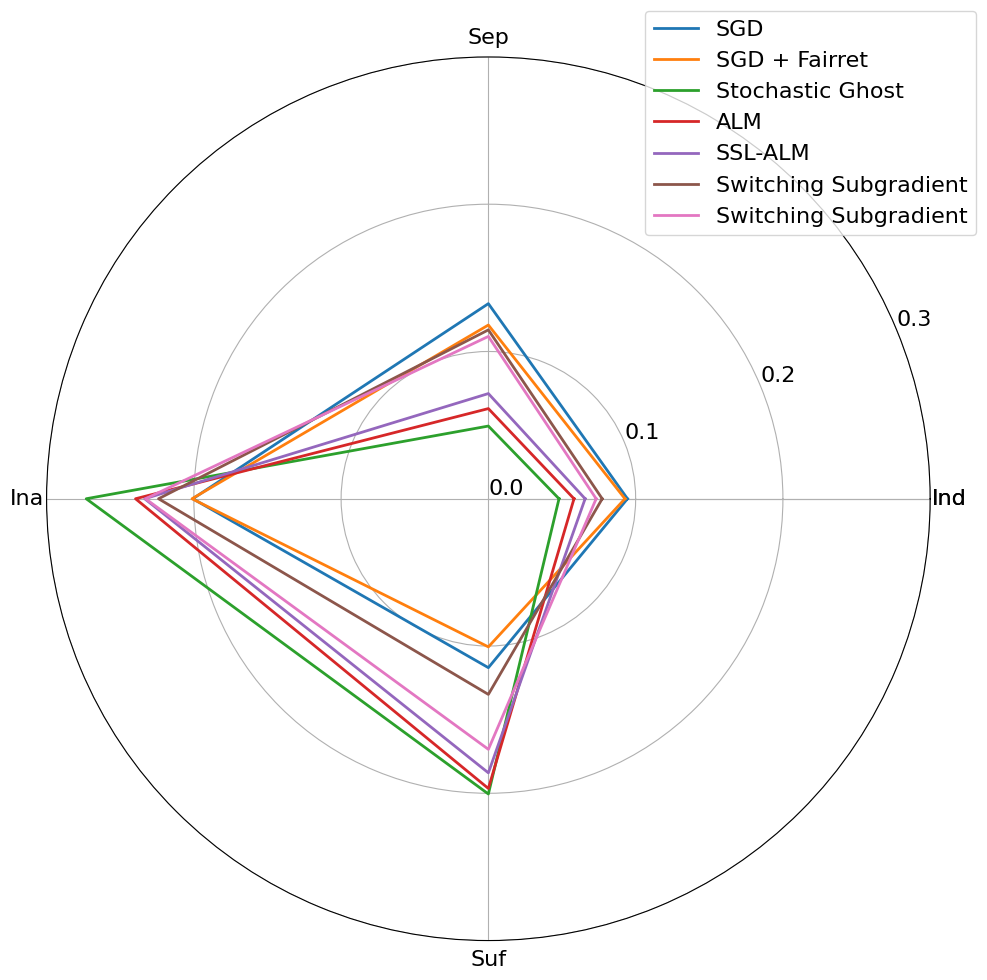

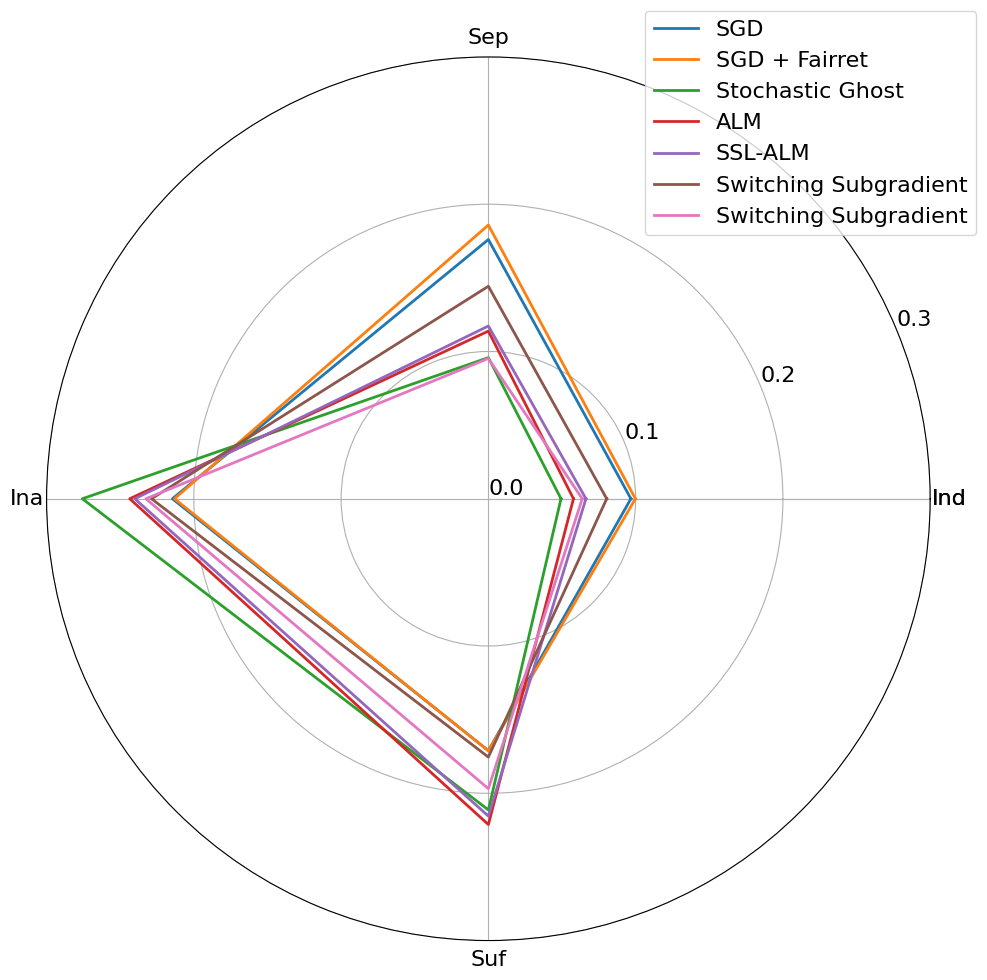

In [17]:
def spider_line(data, title=None):
    plt.rcParams.update({'font.size': 16})
    
    labels = ['Ind', 'Sep', 'Ina', 'Suf']
    # Number of variables we're plotting.
    num_vars = len(labels)

    # Split the circle into even parts and save the angles
    # so we know where to put each axis.
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    # and append the start value to the end.
    angles += angles[:1]
    labels += labels[:1]

    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(polar=True))

    for alg in data.index:
        values = data.loc[alg, ['Ind', 'Sp', 'Ina','Sf', 'Ind']].tolist()
        ax.plot(angles, values, lw=2, label=get_alg_name(alg))
        # ax.plot(angles, values, lw=2, label=alg)
        ax.set_yticks([0,0.1,0.2, 0.3])

    plt.thetagrids(np.degrees(angles), labels=labels)
    if title:
        ax.set_title(title)
    fig.legend()
    fig.tight_layout()
    return fig

f = spider_line(train_df)
f = spider_line(test_df)


**Optimal thresholds:**

In [18]:
results_list_nr = []

with torch.inference_mode():
    for model_index, model_iter in enumerate(loaded_models):
        # Set the model to evaluation mode
        (model_name, model) = model_iter
        model.eval()

        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)

        # Calculate AUCs for sensitive attribute 0 
        fpr_0, tpr_0, thresholds_0 = roc_curve(y_test_w, predictions_0)
        auc_0 = auc(1-fpr_0, 1-tpr_0)  # AUC for FNR is calculated using TPR as x-axis and 1-FPR as y-axis
        tnr_minus_fnr_0 = (1-fpr_0) - (1-tpr_0)
        # Find the threshold that maximizes TPR - FPR difference
        optimal_threshold_index_0 = np.argmax(tnr_minus_fnr_0)
        optimal_threshold_0 = thresholds_0[optimal_threshold_index_0]

        # Calculate AUCs for sensitive attribute 1 
        fpr_1, tpr_1, thresholds_1 = roc_curve(y_test_nw, predictions_1)
        auc_1 = auc(1-fpr_1, 1-tpr_1)  # AUC for TNR is calculated using 1-FPR as x-axis and TPR as y-axis
        tnr_minus_fnr_1 = (1-fpr_1) - (1-tpr_1)
        # Find the threshold that maximizes TPR - FPR difference
        optimal_threshold_index_1 = np.argmax(tnr_minus_fnr_1)
        optimal_threshold_1 = thresholds_1[optimal_threshold_index_1]
        
        auc_hm = (auc_0*auc_1)/(auc_0+auc_1)
        results_list_nr.append({'Model': str(model_name),
                                            'AUC_Sensitive_0': auc_0,
                                            'AUC_Sensitive_1': auc_1,
                                            'Optimal_Threshold_0': optimal_threshold_0,
                                            'Optimal_Threshold_1': optimal_threshold_1,
                                            'AUC_HM': auc_hm
                                            })
        
    results_df_nr = pd.DataFrame(results_list_nr)

**Distribution of predictions by group:**

In [19]:
predictions_0 = {}
predictions_1 = {}

for model_name, model in loaded_models:
    preds_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    preds_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    try:
        predictions_0[model_name].append(preds_0)
        predictions_1[model_name].append(preds_1)
    except:
        predictions_0[model_name] = [preds_0]
        predictions_1[model_name] = [preds_1]

for name in np.unique([name for name, _ in loaded_models]):
    predictions_0[name] = np.concatenate(predictions_0[name])
    predictions_1[name] = np.concatenate(predictions_1[name])

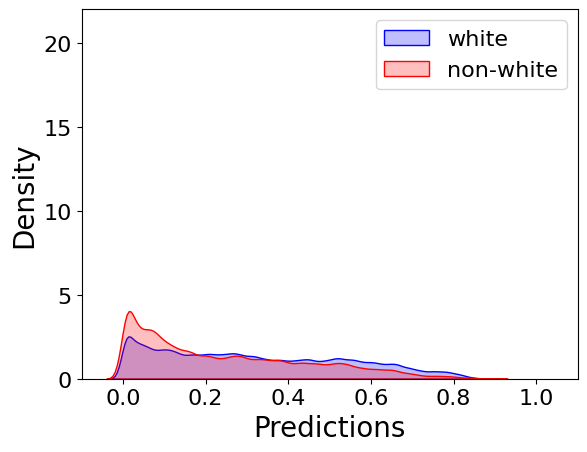

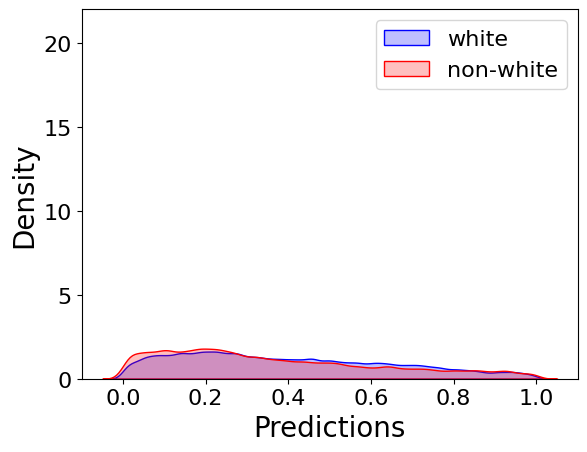

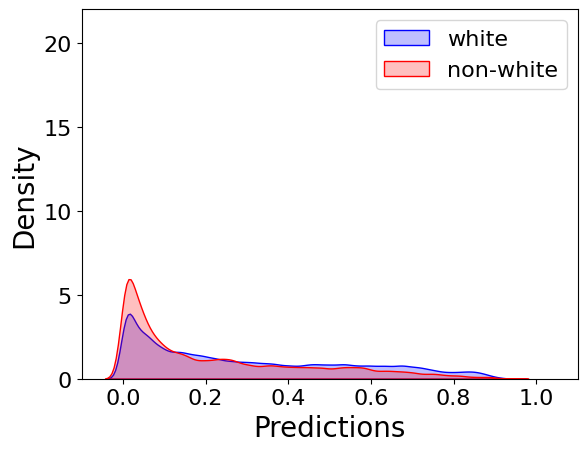

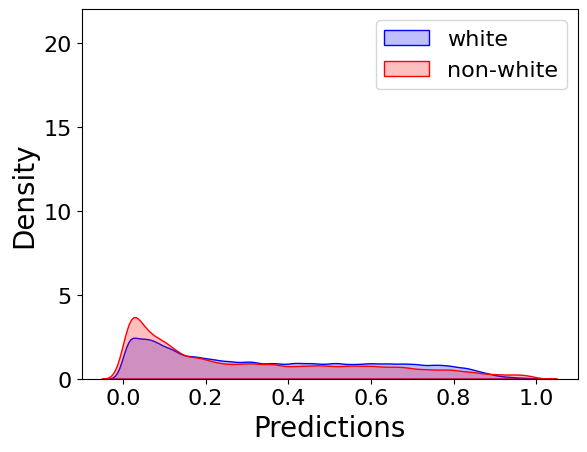

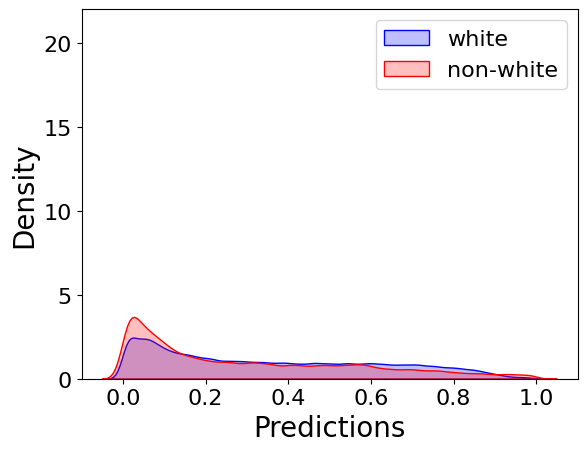

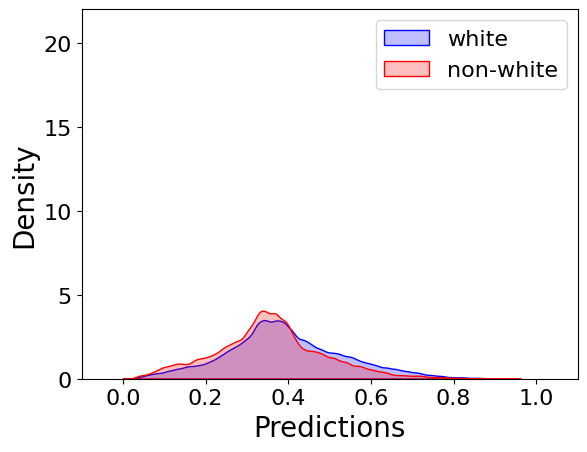

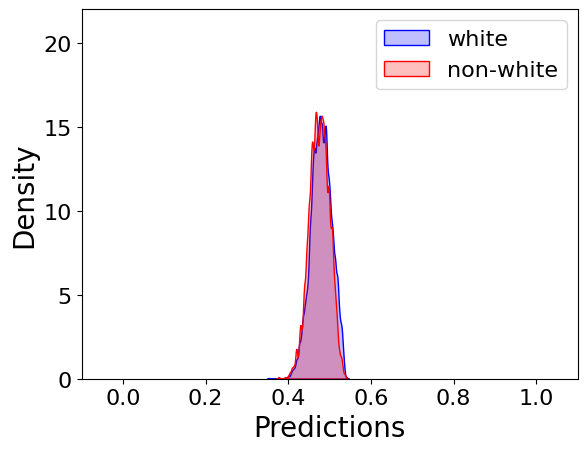

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_name in np.unique([name for name, _ in loaded_models]):

    # predictions_0 = torch.nn.functional.sigmoid(model(X_test_w)).detach().numpy()
    # predictions_1 = torch.nn.functional.sigmoid(model(X_test_nw)).detach().numpy()
    
    sns.kdeplot(predictions_0[model_name].squeeze(), label=sensitive_value_0, color='blue', fill=True,bw_adjust=.4)#,clip=[0,1],common_norm=True)
    sns.kdeplot(predictions_1[model_name].squeeze(), label=sensitive_value_1, color='red', fill=True,bw_adjust=.4)#,clip=[0,1],common_norm=True)
    plt.xlim(-0.1, 1.1)
    plt.ylim(0,22)
    plt.xlabel('Predictions', fontsize=20)
    plt.ylabel('Density', fontsize=20)
    # plt.title(model_name, fontsize=10)
    # plt.title(alg)
    # print(alg)
    alg_name = 'sslalm_aug' if model_name.startswith('sslalm_mu0') else model_name.split('_')[0]
    plt.savefig(f'./plots/{alg_name}/{DATASET}/dist')
    plt.legend()
    plt.show()

### **Model plots**

**We choose one model per algorithm to make some useful plots**

For now, choose the model with the highest mean AUC:

In [21]:
select_by = 'auc'

In [22]:
best_models = {}
algs = res_df_test.Algorithm.unique()
for alg in algs:
    alg_df = res_df_test[res_df_test.Algorithm == alg]
    if select_by == 'auc':
        model = loaded_models[alg_df.AUC_M.idxmax()]
    elif select_by == 'wd':
        model = loaded_models[alg_df.Wd.idxmin()]
    best_models[alg] = model

#### Subgroup ROC

**TPR-FPR plot**

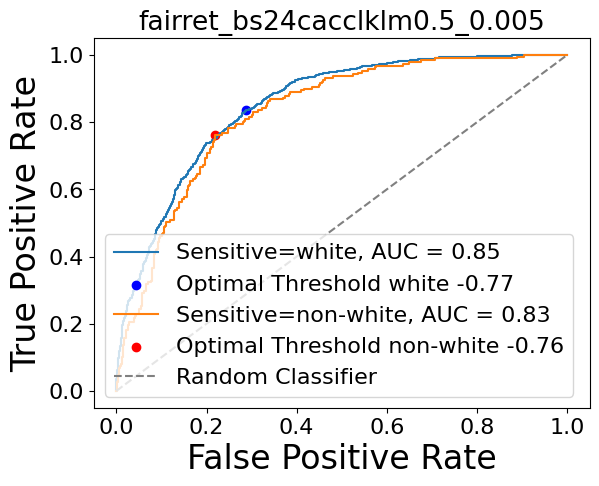

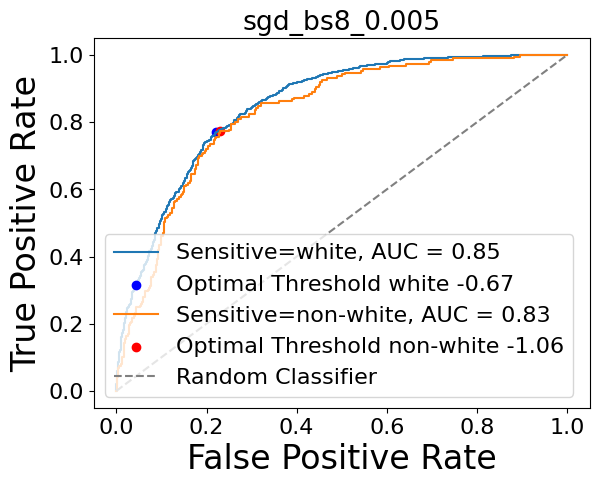

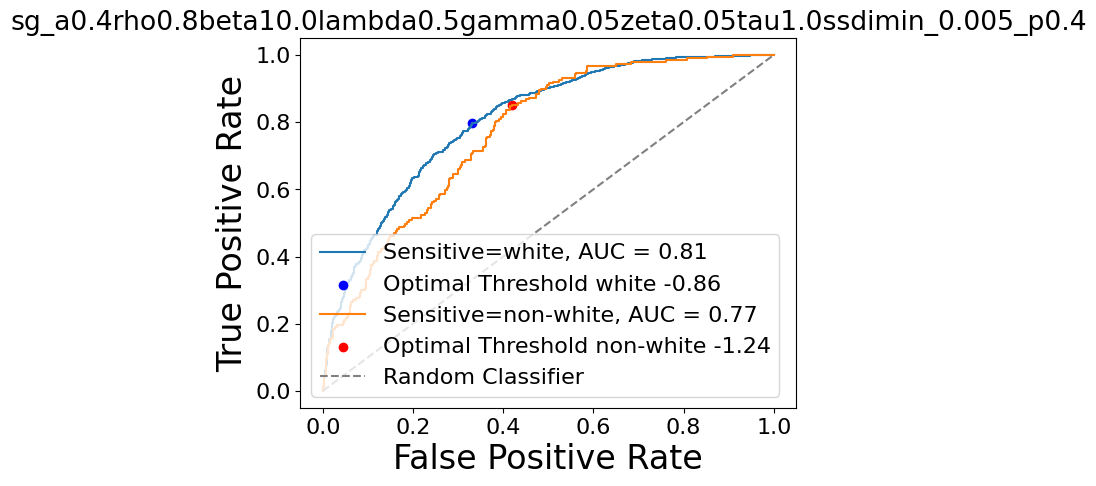

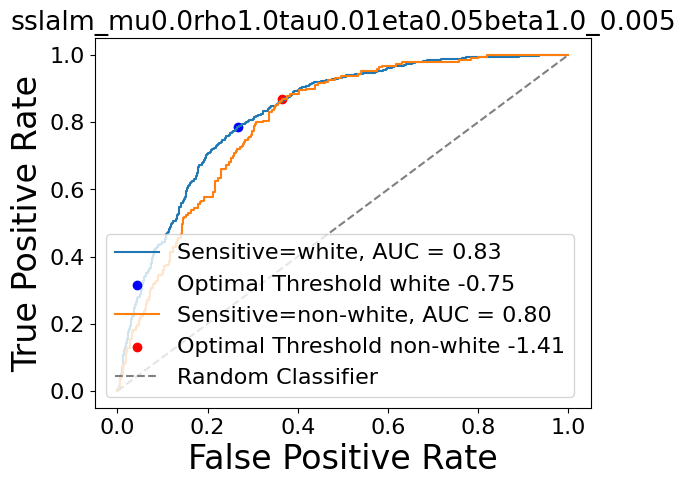

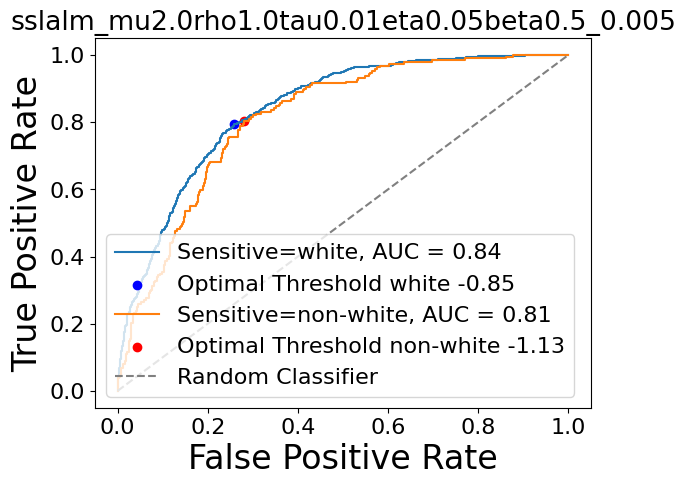

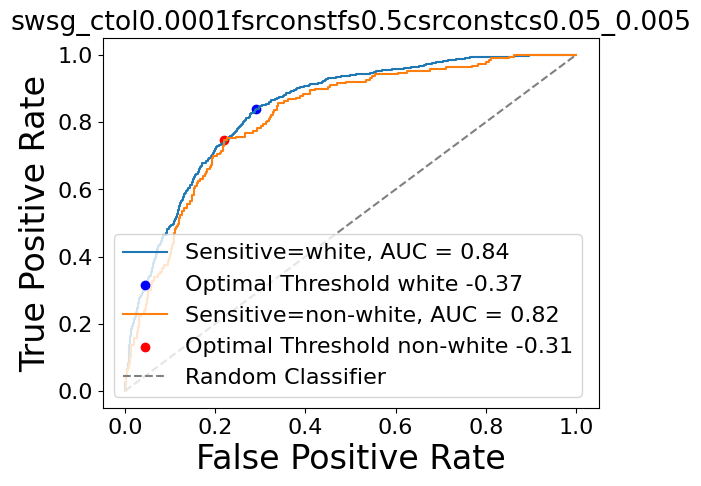

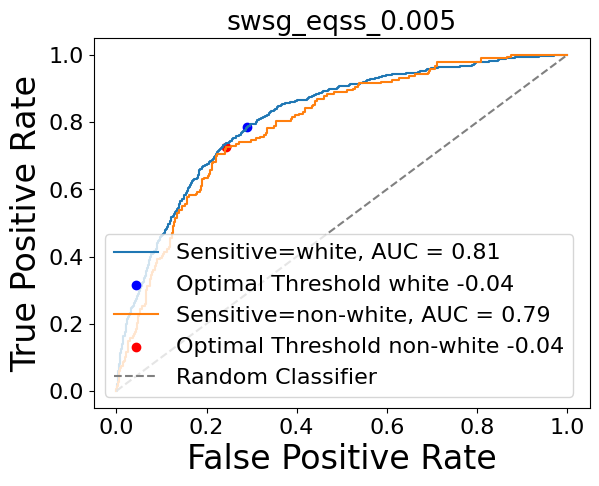

In [23]:
from sklearn.metrics import roc_curve, auc

# Function to generate predictions and plot ROC curve
def plot_roc_curve_pr(ax, predictions, targets, sensitive_value):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')
    tpr_minus_fpr = tpr - fpr
    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tpr_minus_fpr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    
for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax  =  f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_pr(ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0)
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_pr(ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        ax.set_xlabel('False Positive Rate', fontsize=24)
        ax.set_ylabel('True Positive Rate', fontsize=24)
        ax.legend()

**TNR-FNR plot**

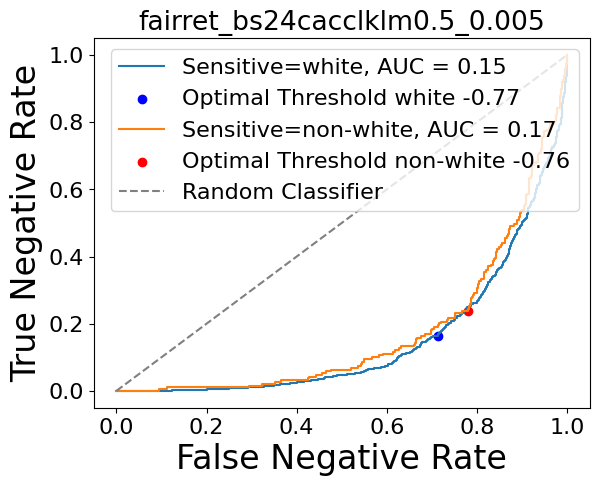

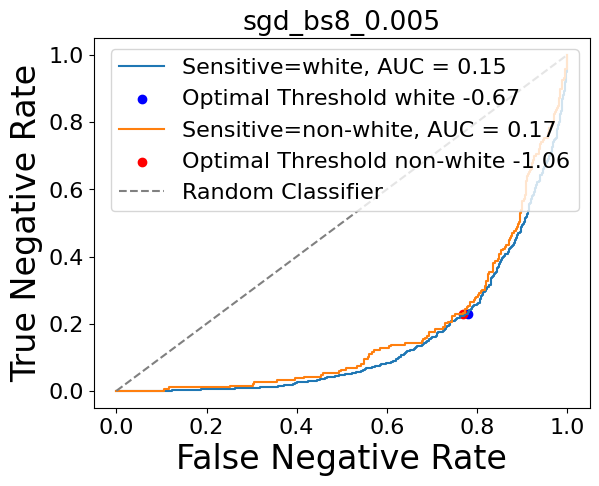

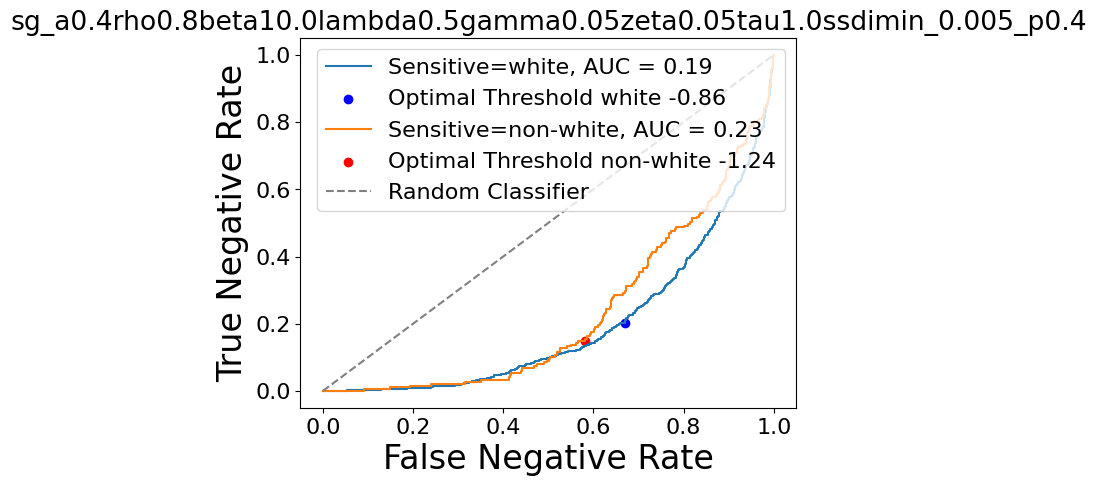

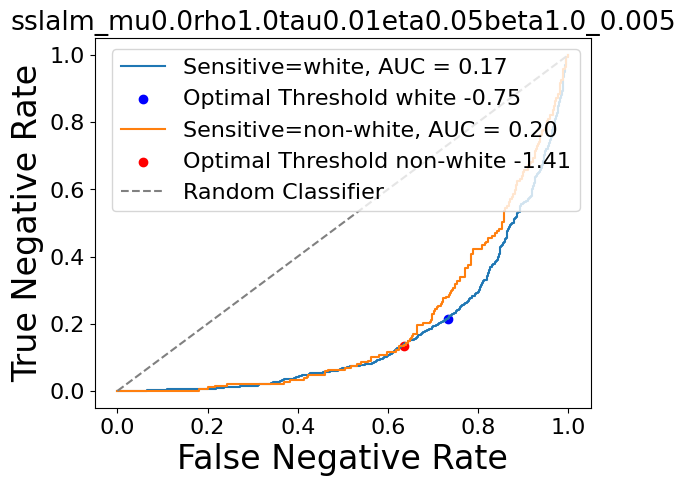

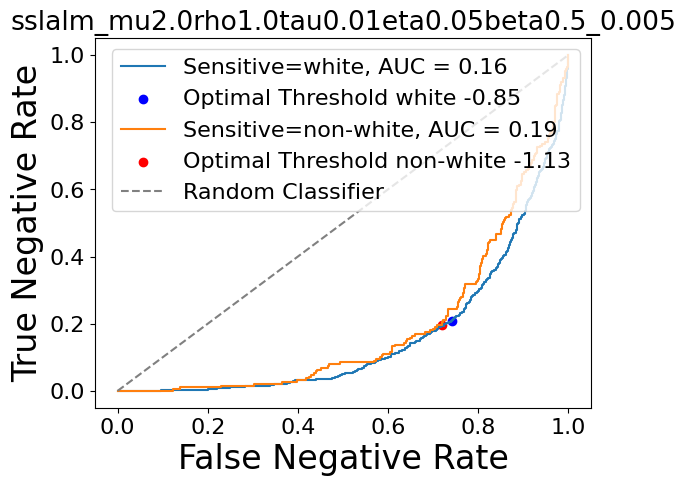

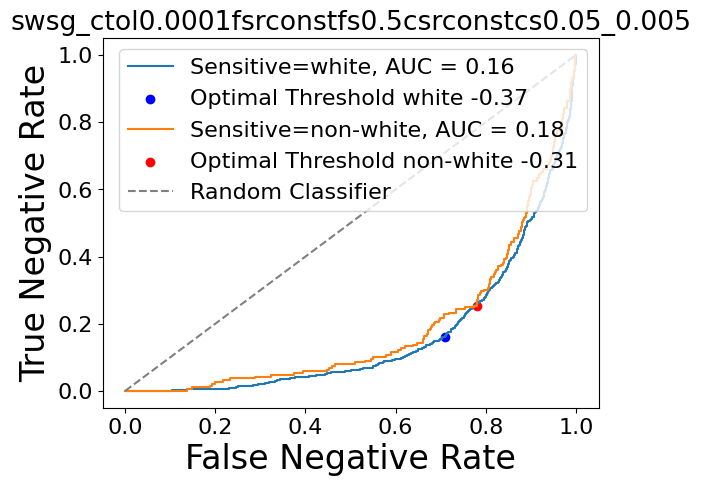

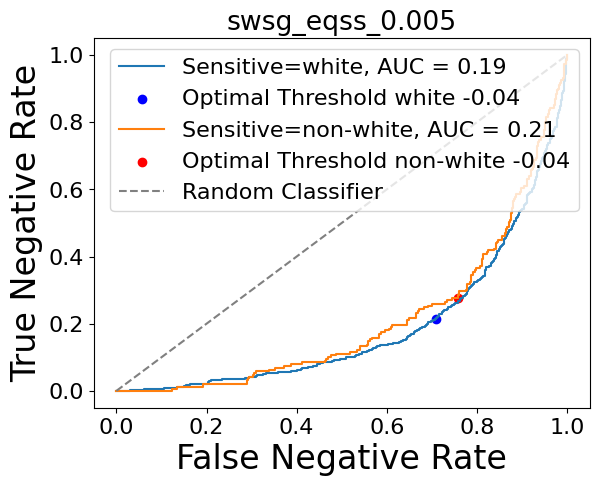

In [24]:
from sklearn.metrics import roc_curve, auc

# Function to generate predictions and plot ROC curve
def plot_roc_curve_nr(ax, predictions, targets, sensitive_value):
    # Convert PyTorch tensors to numpy arrays
    #predictions = predictions.detach().numpy()
    #targets = targets.numpy()

    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(targets, predictions)
    fnr = (1-tpr)
    tnr = (1-fpr)
    roc_auc = auc(tnr, fnr)
    # Plot ROC curve
    ax.plot(tnr, fnr, label=f'Sensitive={sensitive_value}, AUC = {roc_auc:.2f}')

    tnr_minus_fnr = tnr - fnr

    # Find the threshold that maximizes TPR - FPR difference
    optimal_threshold_index = np.argmax(tnr_minus_fnr)
    optimal_threshold = thresholds[optimal_threshold_index]
    ax.scatter(tnr[optimal_threshold_index],fnr[optimal_threshold_index],
                c='blue' if sensitive_value == sensitive_value_0 else 'red',
                label=f'Optimal Threshold {sensitive_value} {optimal_threshold:.2f}')
    
for alg, (model_name, model) in best_models.items():
    f = plt.figure()
    ax  =  f.subplots()
    ax.set_title(alg)
    with torch.inference_mode():
        predictions_0 = model(X_test_w)
        predictions_1 = model(X_test_nw)
        # Plot ROC for sensitive attribute A=0
        plot_roc_curve_nr(ax, predictions_0, y_test_w, sensitive_value=sensitive_value_0)
        # Plot ROC for sensitive attribute A=1
        plot_roc_curve_nr(ax, predictions_1, y_test_nw, sensitive_value=sensitive_value_1)
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
        ax.set_xlabel('False Negative Rate', fontsize=24)
        ax.set_ylabel('True Negative Rate', fontsize=24)
        ax.legend()